# IceCube❄️: Fitting line to 3D point cloud

The goal of this competition is to predict a neutrino particle’s direction. You will develop a model based on data from the "IceCube" detector, which observes the cosmos from deep within the South Pole ice.

The IceCube Neutrino Observatory is the first detector of its kind, encompassing a cubic kilometer of ice and designed to search for the nearly massless neutrinos. An international group of scientists is responsible for the scientific research that makes up the IceCube Collaboration.

By making the process faster and more precise, you'll help improve the reconstruction of neutrinos. As a result, we could gain a clearer image of our universe.

### See related notebooks:

- [IceCube🧊: Neutrino🎆EDA & 3D🔭interactive viewer](https://www.kaggle.com/code/jirkaborovec/icecube-neutrino-eda-3d-interactive-viewer)
- [IceCube❄️: baseline with XGBoost regression](https://www.kaggle.com/code/jirkaborovec/icecube-neutrino-baseline-xgboost-regression)

### Point-cloud 3D fitting

- https://scikit-spatial.readthedocs.io/en/stable/gallery/fitting/plot_line_3d.html

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PATH_DATASET = "/kaggle/input/icecube-neutrinos-in-deep-ice"

## Browse meta data

**[train/test]_meta.parquet**

- **batch_id** (int): the ID of the batch the event was placed into.
- **event_id** (int): the event ID.
- **[first/last]_pulse_index** (int): index of the first/last row in the features dataframe belonging to this event.
- **[azimuth/zenith]** (float32): the [azimuth/zenith] angle in radians of the neutrino. A value between 0 and 2*pi for the azimuth and 0 and pi for zenith. The target columns. Not provided for the test set. The direction vector represented by zenith and azimuth points to where the neutrino came from.

In [2]:
meta_train = pd.read_parquet(os.path.join(PATH_DATASET, "train_meta.parquet"))
display(meta_train.head())

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117


In [3]:
display(meta_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131953924 entries, 0 to 131953923
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   batch_id           int64  
 1   event_id           Int64  
 2   first_pulse_index  int64  
 3   last_pulse_index   int64  
 4   azimuth            float64
 5   zenith             float64
dtypes: Int64(1), float64(2), int64(3)
memory usage: 6.0 GB


None

### azimuth and zenith

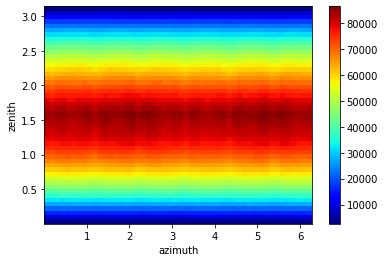

In [4]:
plt.hist2d(meta_train["azimuth"], meta_train["zenith"], bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel('azimuth'), plt.ylabel('zenith')
plt.colorbar()

## Browse geometry

The x, y, and z positions for each of the 5160 IceCube sensors. The row index corresponds to the sensor_idx feature of pulses. The x, y, and z coordinates are in units of meters, with the origin at the center of the IceCube detector. The coordinate system is right-handed, and the z-axis points upwards when standing at the South Pole.

In [5]:
geometry = pd.read_csv(os.path.join(PATH_DATASET, "sensor_geometry.csv"))
print(f"length: {len(geometry)}")
geometry.head()

length: 5160


,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95


In [6]:
import plotly.express as px

fig = px.scatter_3d(geometry, x='x', y='y', z='z', opacity=0.6, color="sensor_id")
fig.update_traces(marker_size=2)
fig.update_layout(height=600, width=600)
fig.show()

In [7]:
geometry.set_index("sensor_id", inplace=True)
geometry = geometry.apply(np.float32)
geometry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5160 entries, 0 to 5159
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       5160 non-null   float32
 1   y       5160 non-null   float32
 2   z       5160 non-null   float32
dtypes: float32(3)
memory usage: 100.8 KB


## Browse training/test data

**[train/test]/batch_[n].parquet** Each batch contains tens of thousands of events. Each event may contain thousands of pulses, each of which is the digitized output from a photomultiplier tube and occupies one row.

- **event_id** (int): the event ID. Saved as the index column in parquet.
- **sensor_id** (int): the ID of which of the 5160 IceCube photomultiplier sensors recorded this pulse.
- **auxiliary** (bool): If True, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise. If False, then this pulse was contributed to the trigger decision and the pulse was fully digitized.

In [8]:
train = pd.read_parquet(os.path.join(PATH_DATASET, "train/batch_15.parquet"))
print(f"length: {len(train)}")
print(f"events: {len(train.index.unique())}")
train.head()

length: 32462509
events: 200000


,sensor_id,time,charge,auxiliary
event_id,,,,
45566128,541,6579,0.625,True
45566128,608,7373,0.825,True
45566128,3972,9208,0.625,True
45566128,619,9374,0.875,True
45566128,2790,9379,0.775,True


## Fitting line to points

In [9]:
! pip install -q scikit-spatial --no-index -f /kaggle/input/icecube-neutrino-eda-3d-interactive-viewer/frozen-packages/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pynndescent 0.5.8 requires importlib-metadata>=4.8.1; python_version < "3.8", but you have importlib-metadata 1.7.0 which is incompatible.
pydocstyle 6.2.2 requires importlib-metadata<5.0.0,>=2.0.0; python_version < "3.8", but you have importlib-metadata 1.7.0 which is incompatible.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 1.7.0 which is incompatible.
lightning-utilities 0.5.0 requires importlib-metadata>=4.0.0; python_version < "3.8", but you have importlib-metadata 1.7.0 which is incompatible.
keyring 23.6.0 requires importlib-metadata>=3.6; python_version < "3.10", but you have importlib-metadata 1.7.0 which is incompatible.
ibis-framework 2.1.1 requires importlib-metadata<5,>=4; python_version < "3.8", but you have importlib-metadata 1.7.0 which 

see the angle visualisation in https://www.kaggle.com/code/jirkaborovec/icecube-visualize-azimuth-zenith

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Kugelkoord-lokale-Basis-s.svg/1024px-Kugelkoord-lokale-Basis-s.svg.png" width="400" height="400"/>

In [10]:
import math
import warnings
warnings.filterwarnings('ignore')

def cartesian_to_sphere(x, y, z):
    # https://en.wikipedia.org/wiki/Spherical_coordinate_system
    x2y2 = x**2 + y**2
    r = math.sqrt(x2y2 + z**2)
    azimuth = math.acos(x / math.sqrt(x2y2)) * np.sign(y)
    zenith = math.acos(z / r)
    return azimuth, zenith

def adjust_sphere(azimuth, zenith):
    if zenith < 0:
        zenith += math.pi
        azimuth += math.pi
    if azimuth < 0:
        azimuth += math.pi * 2
    azimuth = azimuth % (2 * math.pi)
    return azimuth, zenith

def sphere_to_cartesian(azimuth, zenith):
    # see: https://stackoverflow.com/a/10868220/4521646
    x = math.sin(zenith) * math.cos(azimuth)
    y = math.sin(zenith) * math.sin(azimuth)
    z = math.cos(zenith)
    return x, y, z

In [11]:
import plotly.graph_objects as go

def draw_subplot(
    fig, i, evt, sensors, meta, pos_offset, pos_direction, gt_direction, line_len=250
):
    # sensors as background
    fig.add_trace(go.Scatter3d(
        x=sensors['x'], y=sensors['y'], z=sensors['z'], 
        mode='markers', marker=dict(size=1, color="black"), opacity=0.2
    ), row=(i+1), col=1)
    # sensors reading
    evt_time_min, evt_time_max = min(evt['time']), max(evt['time'])
    evt.loc[:, 'time'] = (evt['time'] - evt_time_min) / (evt_time_max - evt_time_min)
    fig.add_trace(go.Scatter3d(
        x=evt['x'], y=evt['y'], z=evt['z'], opacity=0.95,
        mode='markers', marker=dict(
            size=evt['charge'] * 15, color=evt['time'], colorscale='sunsetdark'
        )
    ), row=(i+1), col=1)
    # direction from metad data
    ox, oy, oz = pos_offset
    
    for c, (x, y, z) in [('red', pos_direction), ('green', gt_direction)]:
        fig.add_trace(go.Scatter3d(
            x=[ox - x * line_len, ox + x * line_len],
            y=[oy - y * line_len, oy + y * line_len],
            z=[oz - z * line_len, oz + z * line_len],
            opacity=0.8, mode='lines', line=dict(color=c, width=3)
        ), row=(i+1), col=1)
        fig.add_trace(go.Scatter3d(
            x=[ox - x * line_len],
            y=[oy - y * line_len],
            z=[oz - z * line_len],
            opacity=0.8, mode='markers', marker=dict(size=5, color=c)
        ), row=(i+1), col=1)

### Sample event

In [12]:
from copy import copy
from plotly.subplots import make_subplots
from skspatial.objects import Line, Point, Points


# def sample_directions(evt, line):
#     line_ = copy(line)
#     evt_charge = evt[evt['charge'] >= evt['charge'].mean()]
#     points = evt_charge.sort_values('time')[['x', 'y', 'z']]
#     projs = []
#     for i, (_, point) in enumerate(points[:len(points) // 2].iterrows()):
#         line_.point = Point(point.values)
#         points_ = Points(points[i:].sample(2).values)
#         projs += np.sign(line_.transform_points(points_)).tolist()


def show_event(event_id=46528394, data=train, sensors=geometry, metadata=meta_train):
    event = data[data.index == event_id]
    event = event.merge(sensors, left_on="sensor_id", right_index=True)
    meta = dict(metadata[metadata["event_id"]==event_id].iloc[0])
    print(meta)
    
    evt_ = event[~event['auxiliary']]
    points = Points(evt_[["x", "y", "z"]].values)
    line = Line.best_fit(points, full_matrices=False)
    print(f"Estimate: {line}")
    # sample_directions(evt_, line)
    
    print(f"provided/GT of azimuth={meta['azimuth']:0.5}; zenith={meta['zenith']:0.5}")
    azimuth_, zenith_ = cartesian_to_sphere(*line.direction)
    print(f"predictions of azimuth={azimuth_:0.5} & zenith={zenith_:0.5}")
    azimuth_, zenith_ = adjust_sphere(azimuth_, zenith_)
    print(f"correction of azimuth={azimuth_:0.5} & zenith={zenith_:0.5}")
    
    auxiliaries = [False, True]
    fig = make_subplots(
        rows=2, specs=[[{'type': 'scene'}], [{'type': 'scene'}]],
        subplot_titles=[f"auxiliary={aux}" for aux in auxiliaries],
        vertical_spacing=0.05,
    )
    event.loc[:, 'charge'] = event['charge'] / max(event['charge'])
    x_, y_, z_ = sphere_to_cartesian(meta['azimuth'], meta['zenith'])
    for i, aux in enumerate(auxiliaries):
        draw_subplot(
            fig, i, event[event['auxiliary'] == aux], sensors, meta,
            line.point, line.direction, gt_direction=(x_, y_, z_),
        )
    desc_gt = f"azimuth={meta['azimuth']:0.3}; zenith={meta['zenith']:0.3}"
    desc_gt += f"\n -> x={x_:0.2}; y={y_:0.2}; z={z_:0.2}"
    fig.update_layout(
        height=800, width=600, showlegend=False,
        title_text=f"Event #{event_id} / {desc_gt}",
    )
    return fig

show_event().show()

{'batch_id': 15.0, 'event_id': 46528394.0, 'first_pulse_index': 9699041.0, 'last_pulse_index': 9699108.0, 'azimuth': 4.870578405540633, 'zenith': 1.9638403862989229}
Estimate: Line(point=Point([494.40594, 271.4363 , 259.52164], dtype=float32), direction=Vector([ 0.29944703, -0.36803198, -0.88027495], dtype=float32))
provided/GT of azimuth=4.8706; zenith=1.9638
predictions of azimuth=-0.88779 & zenith=2.6472
correction of azimuth=5.3954 & zenith=2.6472


### Interactive - browse events

**This one is an interactive chart when you can slide over all event in the training batch**

but to get in you need to ioen the notebook in edior mode (so to copy as your own)

In [13]:
from ipywidgets import interact, IntSlider

def interactive_show(events):
    interact(
        lambda i: show_event(events[i]).show(),
        i=IntSlider(min=0, max=len(events), step=1, value=len(events) // 2),
    )

events = train.index.unique().tolist()
interactive_show(events)

interactive(children=(IntSlider(value=100000, description='i', max=200000), Output()), _dom_classes=('widget-i…

In [14]:
import gc, time

del train, meta_train, events
gc.collect(), time.sleep(9)

(880, None)

## Prepare submission¶

An example submission with the correct columns and properly ordered event IDs. The sample submission is provided in the parquet format so it can be read quickly but your final submission must be a csv.

In [15]:
ssub = pd.read_parquet(os.path.join(PATH_DATASET, "sample_submission.parquet"))
ssub.set_index("event_id", inplace=True)
display(ssub.head())

,azimuth,zenith
event_id,,
2092,1,1
7344,1,1
9482,1,1


In [16]:
ssub = ssub.apply(np.float32)
display(ssub.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 2092 to 9482
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   azimuth  3 non-null      float32
 1   zenith   3 non-null      float32
dtypes: float32(2)
memory usage: 48.0+ bytes


None

### Fitting to all data

In [17]:
ls = glob.glob(os.path.join(PATH_DATASET, "test", "*.parquet"))

for batch_file in ls:
    print(f"processing: {batch_file}")
    df = pd.read_parquet(batch_file)
    # del df['time'], df['charge']
    # display(df.head())
    gc.collect()
    
    for eid, dfg in df.groupby("event_id"):
        dfg = dfg[~dfg['auxiliary']]
        dfg = dfg.merge(geometry, left_on="sensor_id", right_index=True)
        # TODO: for memory reason subsample point cloud
        if len(dfg) > 800:
            dfg = dfg.sort_values('charge', ascending=False)[:800]
        # display(dfg)

        try:
            points = Points(dfg[["x", "y", "z"]].values)
            line = Line.best_fit(points, full_matrices=False)
            # TOOD: adjust by timeseriers
            direction_ = -1 * line.direction
            azimuth_, zenith_ = adjust_sphere(*cartesian_to_sphere(*direction_))
        except Exception as ex:
            azimuth_, zenith_ = 0., 0.
            print(ex)
        else:
            ssub.at[eid, "azimuth"] = azimuth_
            ssub.at[eid, "zenith"] = zenith_
        if len(df) < 1e5:
            print(f"Estimation {line} with azimuth={azimuth_} & zenith={zenith_}")

    del df, dfg
    gc.collect(), time.sleep(9)

processing: /kaggle/input/icecube-neutrinos-in-deep-ice/test/batch_661.parquet
Estimation Line(point=Point([-296.65826, -451.36334, -451.6051 ], dtype=float32), direction=Vector([-0.45348912, -0.5924518 , -0.66584414], dtype=float32)) with azimuth=0.9174836368608342 & zenith=0.8421716393498261
Estimation Line(point=Point([ 237.78   , -442.42   ,  339.77002], dtype=float32), direction=Vector([-0.,  0., -1.], dtype=float32)) with azimuth=nan & zenith=0.0
Estimation Line(point=Point([-303.9991  ,  -40.429996, -179.57089 ], dtype=float32), direction=Vector([0.35899684, 0.9331034 , 0.02096076], dtype=float32)) with azimuth=4.345111595300284 & zenith=1.591758624995532


### Finalize submission

In [18]:
ssub.fillna(0).to_csv('submission.csv', index=True)

!head submission.csv

event_id,azimuth,zenith
2092,0.9174836,0.84217167
7344,0.0,0.0
9482,4.3451114,1.5917586
